- Used Source (PyTorch): https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial3/Tutorial3.ipynb; https://www.youtube.com/watch?v=CwsPoa7z2c8
- Other Sources: 
 - PyTorch: https://github.com/gordicaleksa/pytorch-GAT/tree/main?tab=readme-ov-file#visualization-tools
 - PyTorch: https://github.com/sn0218/pyGAT/tree/master
 - Official Paper Code, but with TensorFlow: https://github.com/PetarV-/GAT

In [6]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid 
import torch_geometric.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 

### 1) Cora Dataset

In [4]:
name_data = 'Cora'
dataset = Planetoid(root='/tmp/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()

print(f"Number of Classes in {name_data}:", dataset.num_classes)
print(f"Number of Node Features in {name_data}:", dataset.num_node_features)

Number of Classes in Cora: 7
Number of Node Features in Cora: 1433


Processing...
Done!
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch_geometric/io/fs.py:215: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

In [7]:
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1

        self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout = 0.6)
        self.conv2 = GATConv(self.hid*self.in_head, dataset.num_classes, concat=False, 
                             heads=self.out_head, dropout=0.6)
        
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.dropout(x, p = 0.6, training = self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p = 0.6, training = self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

#### a) Training

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

model = GAT().to(device)
data = dataset[0].to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.005, weight_decay = 5e-4)

model.train()
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])

    if epoch%200 == 0:
        print(loss)
    
    loss.backward()
    optimizer.step()

tensor(1.9496, grad_fn=<NllLossBackward0>)
tensor(0.7106, grad_fn=<NllLossBackward0>)
tensor(0.4881, grad_fn=<NllLossBackward0>)
tensor(0.6119, grad_fn=<NllLossBackward0>)
tensor(0.5462, grad_fn=<NllLossBackward0>)


#### b) Evaluation

In [9]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.8320


#### c) Visualizing Node Embeddings with t-SNE

- Could visualize feature representaitons from:
 - First hidden layer: This layer often shows how the model is starting to organize nodes by their class while still preserving some of the original feature structure. The first hidden layer typically shows clearer class separation than the input features but with richer representation than later layers
 - Final layer: The final layer embeddings are directly optimized for classification, so they tend to form very distinct clusters by class
 - Intermediate layers: Can show progressive transformation of node representaitons.
 

perplexity : float, default=30.0
- The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. Different values can result in significantly different results. The perplexity must be less than the number of samples.

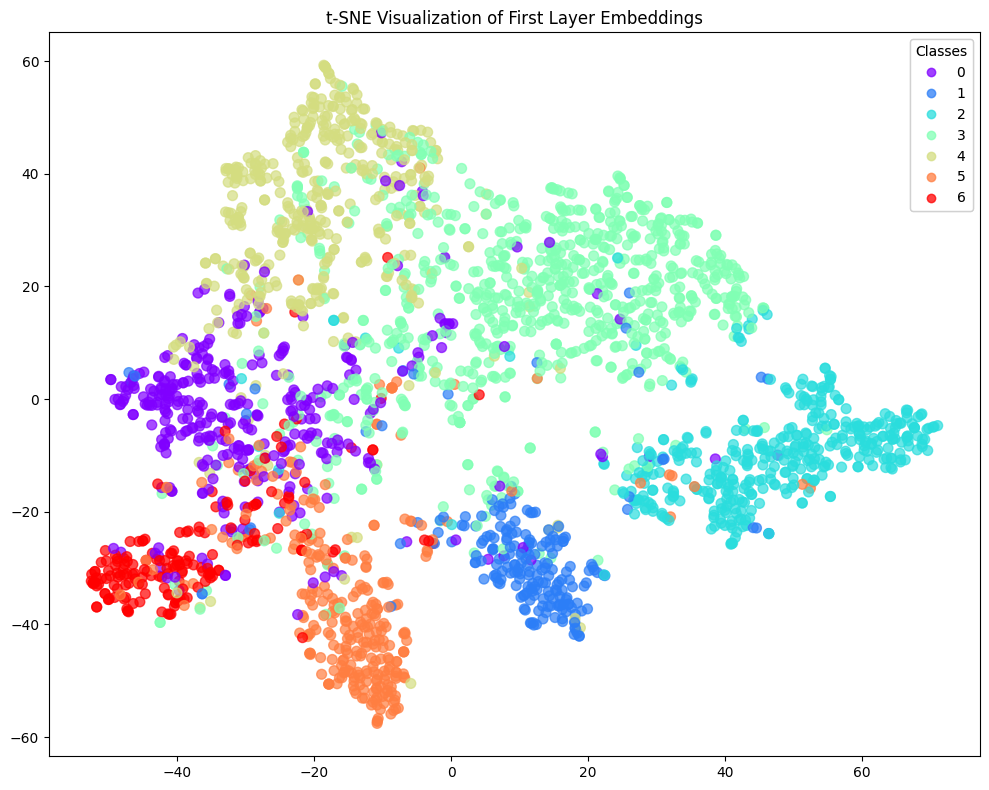

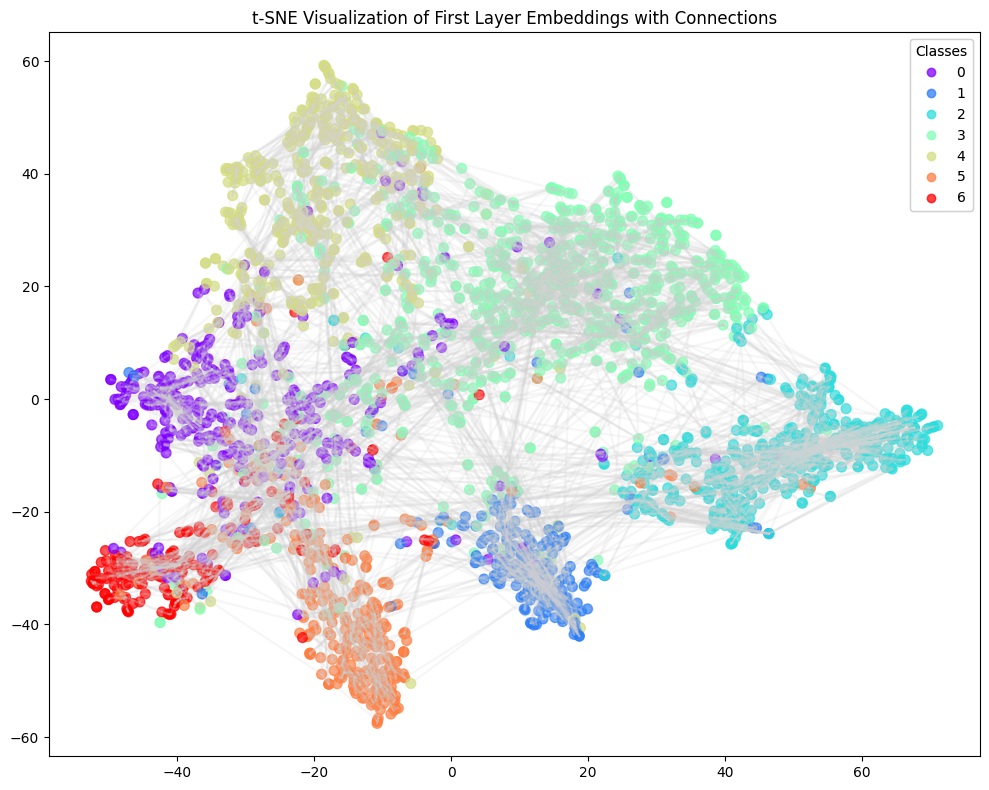

In [17]:
import numpy as np 
from sklearn.manifold import TSNE

# Function to extract embeddings and visualize t-SNE with two plots
def visualize_tsne_dual_plots(model, data, layer='first'):
    model.eval()
    with torch.no_grad():
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=False)
        
        # Get embeddings from the specified layer
        if layer == 'first':
            embeddings = model.conv1(x, edge_index)
        elif layer == 'final':
            x = model.conv1(x, edge_index)
            x = F.elu(x)
            x = F.dropout(x, p=0.6, training=False)
            embeddings = model.conv2(x, edge_index)
        
        # Convert to numpy for t-SNE
        embeddings = embeddings.detach().cpu().numpy()
        
        # Apply t-SNE
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        embeddings_2d = tsne.fit_transform(embeddings)
        
        # Get labels for coloring
        labels = data.y.cpu().numpy()
        
        # PLOT 1: Only embeddings
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                             c=labels, cmap='rainbow', alpha=0.7, s=50)
        
        # Add legend
        legend1 = plt.legend(*scatter.legend_elements(),
                            title="Classes")
        plt.gca().add_artist(legend1)
        
        plt.title(f't-SNE Visualization of {layer.capitalize()} Layer Embeddings')
        plt.tight_layout()
        #plt.savefig(f'gat_tsne_{layer}_embeddings_only.png', dpi=300)
        plt.show()
        
        # PLOT 2: Embeddings with connections
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                             c=labels, cmap='rainbow', alpha=0.7, s=50)
        
        # Add legend
        legend1 = plt.legend(*scatter.legend_elements(),
                            title="Classes")
        plt.gca().add_artist(legend1)
        
        # Add connections between nodes
        edge_index_np = edge_index.cpu().numpy()
        for i, j in zip(edge_index_np[0], edge_index_np[1]):
            plt.plot([embeddings_2d[i, 0], embeddings_2d[j, 0]],
                     [embeddings_2d[i, 1], embeddings_2d[j, 1]],
                     'lightgray', alpha=0.1)  # Light gray lines for edges
        
        plt.title(f't-SNE Visualization of {layer.capitalize()} Layer Embeddings with Connections')
        plt.tight_layout()
        #plt.savefig(f'gat_tsne_{layer}_with_connections.png', dpi=300)
        plt.show()

# Run the function - visualize the first layer embeddings
visualize_tsne_dual_plots(model, data, layer='first')

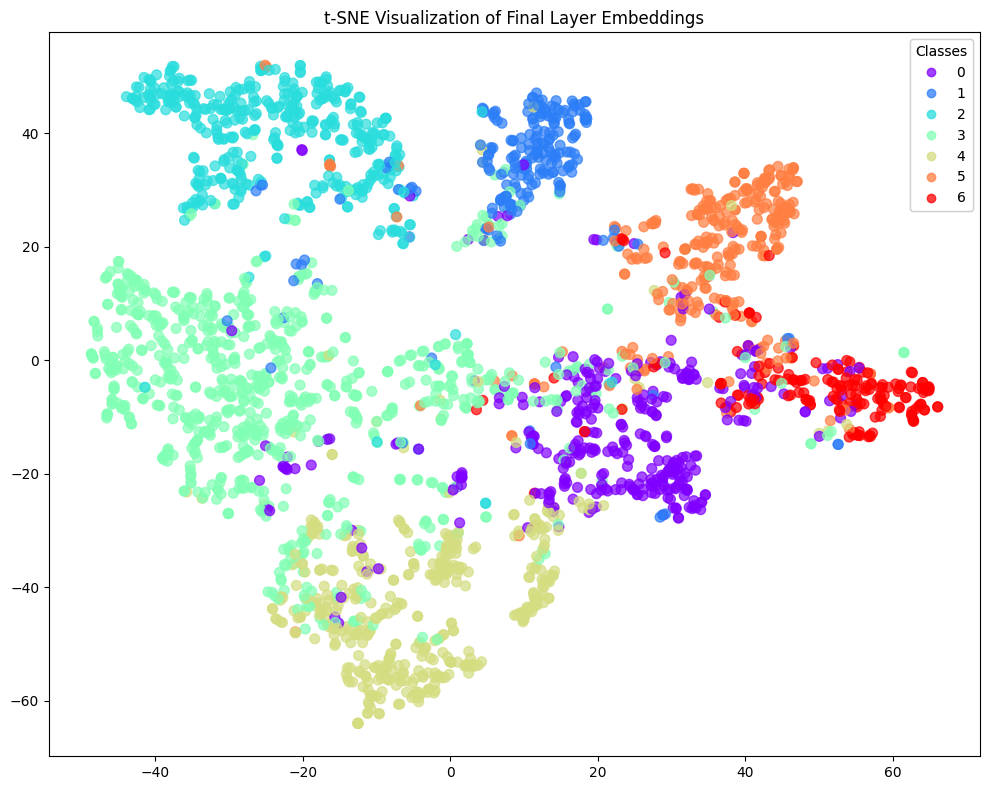

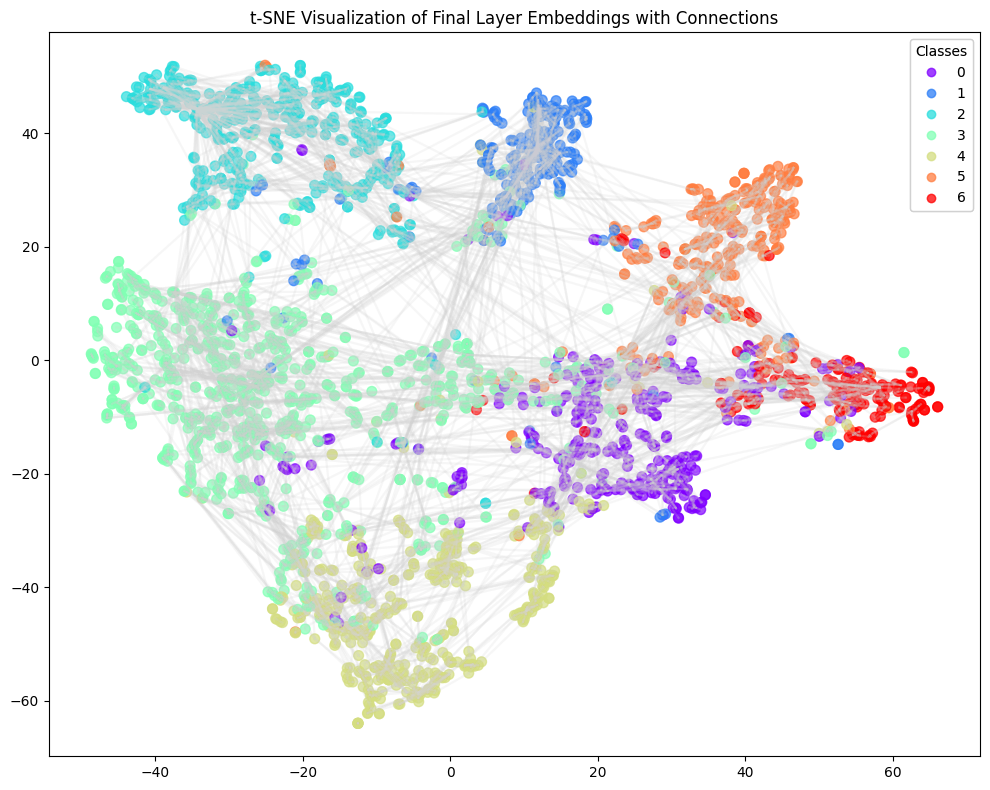

In [18]:
# Run the function - visualize the first layer embeddings
visualize_tsne_dual_plots(model, data, layer='final')

#### d) Visualizing Attention Weights between Nodes with Networkx, Plotly, PyVis, Graph-tool or Gephi

#### d.1) Networkx

In [27]:
import networkx as nx
import torch_geometric.utils as utils

def visualize_attention(model, data, node_idx=None):
    """ 
    Visualize attention weights for a specific node or the entire graph
    """

    model.eval()

    # We need to hook into the attention mechanism
    # This is specific to the GAT implementation
    attention_weights = []

    # def hook_fn(module, input, output):
    # # Handle different GAT implementations
    #     if isinstance(output, tuple):
    #         if len(output) == 2:
    #             # Common case: (node_features, attention)
    #             _, attention = output
    #         else:
    #             # Some implementations return (node_features, attention, ...)
    #             attention = output[1]
    #     else:
    #         # Some GAT implementations store attention in the module itself
    #         # Try to access it through common attribute names
    #         if hasattr(module, 'alpha'):
    #             attention = module.alpha
    #         elif hasattr(module, 'attention'):
    #             attention = module.attention
    #         elif hasattr(module, 'att_weight'):
    #             attention = module.att_weight
    #         else:
    #             raise ValueError("Could not locate attention weights in the GAT layer. "
    #                         "Please check the implementation details of your GAT model.")
        
    #     # Ensure we have the attention weights in the right format
    #     if attention is not None:
    #         attention_weights.append(attention.detach().cpu())

    def hook_fn(module, input, output):
    # Check if output is a tuple or list
        if isinstance(output, (tuple, list)):
            # Directly select the second element, regardless of tuple length
            attention = output[1]
        else:
            # Otherwise, try to extract from module attributes
            if hasattr(module, 'alpha'):
                attention = module.alpha
            elif hasattr(module, 'attention'):
                attention = module.attention
            elif hasattr(module, 'att_weight'):
                attention = module.att_weight
            else:
                raise ValueError("Could not locate attention weights in the GAT layer. "
                                "Please check the implementation details of your GAT model.")
        
        attention_weights.append(attention.detach().cpu())

    # Register hooks on GAT layers
    handle1 = model.conv1.register_forward_hook(hook_fn)

    # Forward pass to get attention
    with torch.no_grad():
        model(data)
    
    # Remove the hooks
    handle1.remove()

    # Check if we got any attention weights
    if not attention_weights:
        raise ValueError("Could not extract attention weights. Please modify the hook function to match your GAT implementation.")

    # Get the graph structure
    edge_index = data.edge_index.cpu().numpy()
    G = nx.DiGraph()

    # Add nodes
    for i in range(data.num_nodes):
        G.add_node(i)

    
    # Get attention weights from the first layer, first attention head
    # You could average across all heads or look at specific ones
    attn = attention_weights[0]
    if attn.dim() > 2: # If multiple attention heads
        attn = attn.mean(dim=1) # Average across attention heads

    # Add edges with attention weights
    for i, (src, dst) in enumerate(zip(edge_index[0], edge_index[1])):
        G.add_edge(src, dst, weight=attn[i].item())

    # If a specific node is given, only show its neighborhood
    if node_idx is not None:
        neighbors = list(G.neighbors(node_idx))
        subgraph_nodes = [node_idx] + neighbors
        G = G.subgraph(subgraph_nodes)

    # Visualize
    plt.figure(figsize=(12,10))
    pos = nx.spring_layout(G, seed=42)

    # Get node labels
    labels = data.y.cpu().numpy()
    node_colors = labels[list(G.nodes())]

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, 
                           node_color=node_colors,
                           cmap = 'rainbow',
                           node_size = 300, 
                           alpha = 0.8)
    
    # Draw edges with width proportional to attention weight
    edge_weights = [G[u][v]['weight'] * 5 for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width = edge_weights, alpha = 0.5,
                           edge_color = 'gray', arrows = True,
                           arrowsize=15, arrowstyle='->')
    
    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size = 10)

    plt.title("Attention Weights Visualization")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# Visualize attention for one node
visualize_attention(model, data, node_idx=0)
    

ValueError: too many values to unpack (expected 2)